<a href="https://colab.research.google.com/github/Raspberry765/deep-metric-learning/blob/main/SubCenterArcFaceMNIST_LoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmaxによる分類

In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install torchsummary
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torchsummary import summary
import plotly.express as px
import plotly.graph_objects as go
from torch.utils.data.dataset import Subset
from torchvision.models.feature_extraction import create_feature_extractor

In [13]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ##torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1)
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #MNISTのデータはグレースケールだから、channel数は1である
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.25)
        self.dropout3 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(15488, 256)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        ##torch.nn.functional.max_pool2d(input, kernel_size, stride=kernel_size)
        #max_pool2dのstrideのデフォルトはkernel_size
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    loss_list = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        #loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))
            numpy_loss = loss.cpu().detach().numpy()
            loss_list.append(numpy_loss)
            torch.save(model, "model_dml"+ str(epoch)+ "_" + str(batch_idx)  + ".pth")
            #print(numpy_loss)            
    return loss_list


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    ##Test set accuracy (Precision@1) = 0.9872000000000001
    return accuracies["precision_at_1"]




## View some sample outliers

In [14]:


img_mean, img_std = (0.1307,), (0.3081,) #MNISTの平均と標準偏差  https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457 


inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

In [15]:

device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
) #MNISTの平均と標準偏差を画像に対して前処理を行うためのパラメーター



dataset1 = datasets.MNIST("./sample_data/", train=True, download=True, transform=transform) #トランスフォームを適用して、ダウンロード
dataset2 = datasets.MNIST("./sample_data/", train=False, transform=transform) #トランスフォームを適用して、ダウンロード



In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)

model = Net().to("cuda")

test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size) #batch sizeは2**n deep learning C2 w2 optimization algorithms
optimizer = optim.Adam(model.parameters(), lr=0.01)#defalut lr=0.01 #ハイパーパラメーター



### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=256).to(device) #0~9の数字を分類するため　10classに分類する、embedding_sizeは最終出力のunits数
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)#ハイパーパラメーター
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

# train、validation、test datasetの作成
[train set validation testset役割](https://algorithm.joho.info/programming/python/keras-train-validation-test-dataset/)
[リンクテキスト](https://www.youtube.com/watch?v=swCf51Z8QDo)

In [17]:

#print(device)
n_samples = int( len(dataset1) )  # n_samples is 60000
train_size = int( n_samples * 0.8 ) # train_size is 48000
val_size = n_samples - train_size

# shuffleしてから分割してくれる.
train_dataset, val_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size])

print(len(train_dataset)) # 48000
print(len(val_dataset)) # 12000

#print(torch.cuda.is_available())

48000
12000


# Modelの表示

In [18]:
print(model)
summary(model,(1,28,28))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (dropout3): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=15488, out_features=256, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 22, 22]          73,856
         Dropout2d-4          [-1, 128, 11, 11]               0
            Linear-5                  [-1, 256]       3,965,184
Total params: 4,057,856
Trainable params: 4,057,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB):

## Train the model

In [19]:
sum_loss_list = []
acc_list = []
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    loss_list = train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    print(loss_list)
    sum_loss_list.extend(loss_list)
    acc_value = test(dataset1, dataset2, model, accuracy_calculator)
    acc_list.extend([acc_value])
print("sum_loss_list:",sum_loss_list)
print("acc_list:",acc_list)

Epoch 1 Iteration 0: Loss = 35.65904998779297
Epoch 1 Iteration 100: Loss = 10.70421028137207
Epoch 1 Iteration 200: Loss = 4.608978748321533
Epoch 1 Iteration 300: Loss = 3.6495394706726074
Epoch 1 Iteration 400: Loss = 3.2196645736694336
Epoch 1 Iteration 500: Loss = 2.5716919898986816
Epoch 1 Iteration 600: Loss = 1.6644316911697388
Epoch 1 Iteration 700: Loss = 1.8445250988006592
Epoch 1 Iteration 800: Loss = 1.730666160583496
Epoch 1 Iteration 900: Loss = 1.7839514017105103
[array(35.65905, dtype=float32), array(10.70421, dtype=float32), array(4.6089787, dtype=float32), array(3.6495395, dtype=float32), array(3.2196646, dtype=float32), array(2.571692, dtype=float32), array(1.6644317, dtype=float32), array(1.8445251, dtype=float32), array(1.7306662, dtype=float32), array(1.7839514, dtype=float32)]


100%|██████████| 313/313 [00:05<00:00, 57.79it/s]


Computing accuracy


/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)
/usr/local/lib/python3.9/dist-packages/faiss/contrib/torch_utils.py:65: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 8)


Test set accuracy (Precision@1) = 0.9839
Epoch 2 Iteration 0: Loss = 2.8048722743988037
Epoch 2 Iteration 100: Loss = 3.0918800830841064
Epoch 2 Iteration 200: Loss = 1.497689127922058
Epoch 2 Iteration 300: Loss = 2.3213555812835693
Epoch 2 Iteration 400: Loss = 2.129554271697998
Epoch 2 Iteration 500: Loss = 1.6068155765533447
Epoch 2 Iteration 600: Loss = 0.8001816272735596
Epoch 2 Iteration 700: Loss = 1.8406925201416016
Epoch 2 Iteration 800: Loss = 1.9680733680725098
Epoch 2 Iteration 900: Loss = 1.2238543033599854
[array(2.8048723, dtype=float32), array(3.09188, dtype=float32), array(1.4976891, dtype=float32), array(2.3213556, dtype=float32), array(2.1295543, dtype=float32), array(1.6068156, dtype=float32), array(0.8001816, dtype=float32), array(1.8406925, dtype=float32), array(1.9680734, dtype=float32), array(1.2238543, dtype=float32)]


100%|██████████| 313/313 [00:03<00:00, 83.69it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.9875
sum_loss_list: [array(35.65905, dtype=float32), array(10.70421, dtype=float32), array(4.6089787, dtype=float32), array(3.6495395, dtype=float32), array(3.2196646, dtype=float32), array(2.571692, dtype=float32), array(1.6644317, dtype=float32), array(1.8445251, dtype=float32), array(1.7306662, dtype=float32), array(1.7839514, dtype=float32), array(2.8048723, dtype=float32), array(3.09188, dtype=float32), array(1.4976891, dtype=float32), array(2.3213556, dtype=float32), array(2.1295543, dtype=float32), array(1.6068156, dtype=float32), array(0.8001816, dtype=float32), array(1.8406925, dtype=float32), array(1.9680734, dtype=float32), array(1.2238543, dtype=float32)]
acc_list: [0.9839, 0.9875]


# lossをプロットするとaccをプロットする

20


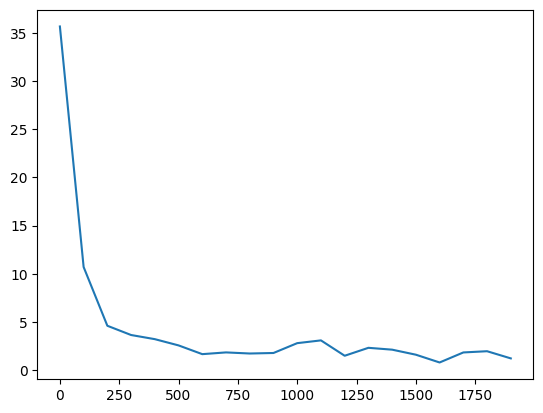

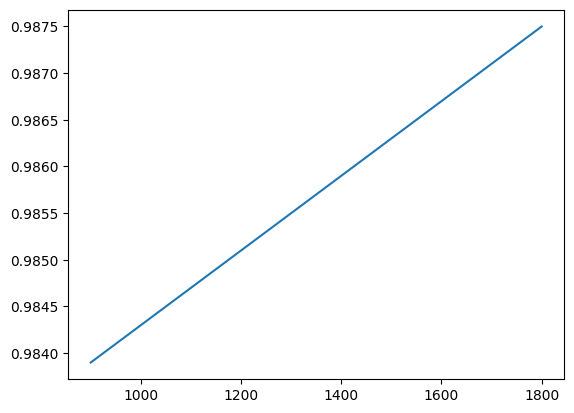

In [20]:
#print(type(loss_list[0]))
print(len(sum_loss_list))
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

x2 = (np.arange(len(acc_list))+1 )*900 #-5から5まで0.1区切りで配列を作る
y2 = acc_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成


plt.plot(x,y) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()
plt.plot(x2,y2) # この場合のplot関数の第一引数xは、x軸に対応し、第二引数のyがy軸にあたります。
plt.show()

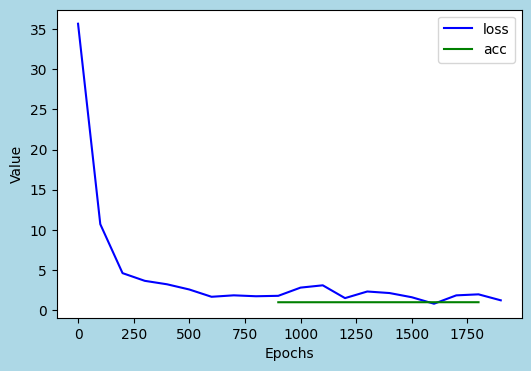

In [21]:
fig = plt.figure(figsize = (6,4), facecolor='lightblue')

c1, c2 = 'blue', 'green'
l1, l2 = 'loss', 'acc'
plt.plot(x, y, color=c1, label=l1)
plt.plot(x2, y2, color=c2, label=l2)

#ラベルを追加
plt.xlabel("Epochs")
plt.ylabel("Value")


# 凡例表示
plt.legend(loc = 'upper right') 

plt.show()

In [22]:
x = np.arange(len(sum_loss_list))*100 #-5から5まで0.1区切りで配列を作る
y = sum_loss_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

fig = go.Figure()
fig.add_trace(
go.Scatter(x=x,y=y)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'Loss'
)
fig.show()

In [36]:
x2 = (np.arange(len(acc_list))+1 )*900 #-5から5まで0.1区切りで配列を作る
y2 = acc_list #配列xの値に関してそれぞれsin(x)を求めてy軸の配列を生成

fig = go.Figure()
fig.add_trace(
go.Scatter(x=x2,y=y2)
)
fig.update_layout(
    xaxis_title = 'Number of Epoch',
    yaxis_title = 'acc'
)
fig.show()

# modelを保存

In [24]:
torch.save(model, 'model_dml.pth')

#modelデータのロードをする
# trainデータを埋め込みする



In [ ]:
load_model = torch.load('model_dml.pth')
train_embeddings, train_labels = get_all_embeddings(dataset1, load_model)

100%|██████████| 1875/1875 [00:20<00:00, 89.65it/s] 


## Get outliers(MNISTの文字データのtrainデータを異常検知している)

There are 95 outliers


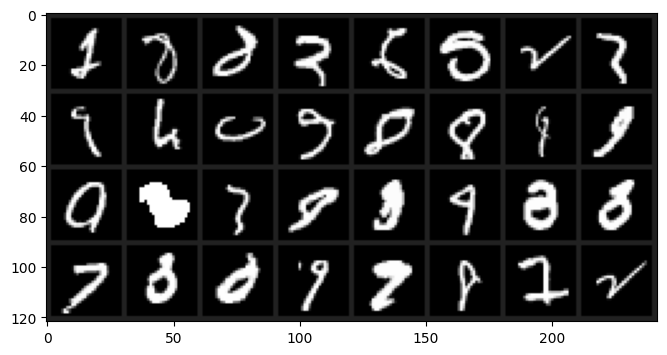

In [ ]:
#get_outliers( embeddings, labels, threshold=75, return_dominant_centers=True)
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers")
imshow_many(dataset1, outliers)

In [ ]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers


# testデータを埋め込みする

In [ ]:
test_embeddings, test_labels = get_all_embeddings(dataset2, model)

100%|██████████| 313/313 [00:04<00:00, 65.23it/s]


## Get outliers(MNISTの文字データのtestデータを異常検知している)

There are 18 outliers(MNIST 10000 test items)


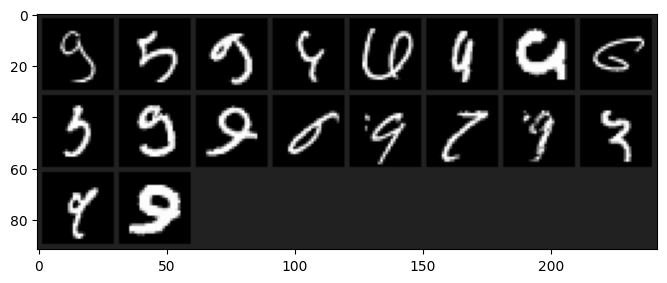

In [ ]:
outliers, _ = loss_func.get_outliers(test_embeddings, test_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(MNIST 10000 test items)")
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset2, outliers)

In [ ]:
# transform to normalize the data
fashion_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
fashion_trainset = datasets.FashionMNIST('.', download=True, train=True, transform=fashion_transform )
fashion_testset = datasets.FashionMNIST('.', download=True, train=False, transform=fashion_transform )

100%|██████████| 26421880/26421880 [00:00<00:00, 114914895.37it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5378410.85it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 64340985.07it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6024630.86it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



# train fashionデータとtest fashionデータを埋め込みする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_fashion_embeddings, train_fashion_labels = get_all_embeddings(fashion_trainset, model)
test_fashion_embeddings, test_fashion_labels = get_all_embeddings(fashion_testset, model)

100%|██████████| 313/313 [00:03<00:00, 85.52it/s] 


In [ ]:
outliers, _ = loss_func.get_outliers(train_fashion_embeddings, train_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 60000 items)")
outliers, _ = loss_func.get_outliers(test_fashion_embeddings, test_fashion_labels.squeeze(1)) #train modelを異常検知している #lr=0.01 outlier=98
print(f"There are {len(outliers)} outliers(train_fashion 10000 items)")

There are 44997 outliers(train_fashion 60000 items)
There are 7509 outliers(train_fashion 10000 items)


64層まで
There are 43690 outliers(train_fashion 60000 items)
There are 7319 outliers(train_fashion 10000 items)

# 中間層の抽出

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
def store_feature(module, input, output):
    global feature
    feature = output


load_model.dropout3.register_forward_hook(store_feature)


# x = torch.rand((1, 1, 28, 28)).float()
# y = load_model(x).to(device)
# print(y.shape)
import torch.multiprocessing as multiprocessing
if multiprocessing.get_start_method() == 'fork':
  multiprocessing.set_start_method('spawn', force=True)
  test_embeddings, test_labels = get_all_embeddings(dataset2, load_model)

100%|██████████| 313/313 [00:10<00:00, 29.28it/s]
